順序尺度を変数を量的変数として使うときは注意

In [1]:
#import some necessary librairies
#https://www.kaggle.com/zhixinzhang/stacked-regressions-top-4-on-leaderboard
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability

from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [2]:
# Get data
train = pd.read_csv("HousePrices_all/train.csv")
test = pd.read_csv("HousePrices_all/test.csv")
# check the numbers of samples and features
print("The train data size before dropping Id feature is : {}".format(train.shape))
print("The test data size before dropping Id feature is : {}".format(test.shape))

train_ID = train["Id"]
test_ID = test["Id"]

#Now drop the "Id" colum since it is unnecessary for the prediction process.
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

#check again the data size after dropping the "Id" var iable
print("\nThe train data size after dropping Id feature is :{}".format(train.shape))
print("The test data size after dropping Id feature is :{}".format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)

The train data size after dropping Id feature is :(1460, 80)
The test data size after dropping Id feature is :(1459, 79)


## Data Processing

### Outliers

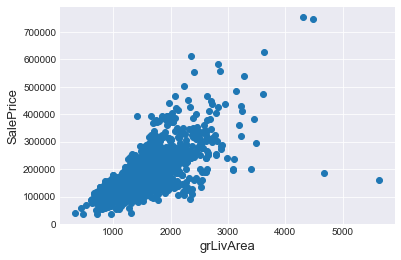

In [3]:
fig, ax = plt.subplots()
ax.scatter(x=train["GrLivArea"], y=train["SalePrice"])
plt.ylabel("SalePrice",fontsize=13)
plt.xlabel("grLivArea",fontsize=13)
plt.show()

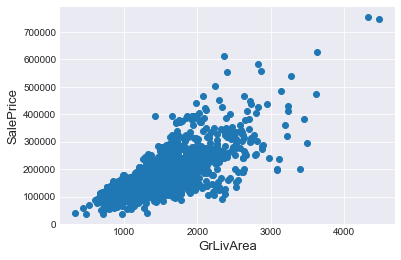

In [4]:
#Deleting outliers
train = train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train["GrLivArea"], train["SalePrice"])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

### Target Variable
---
**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180932.92 and sigma = 79467.79



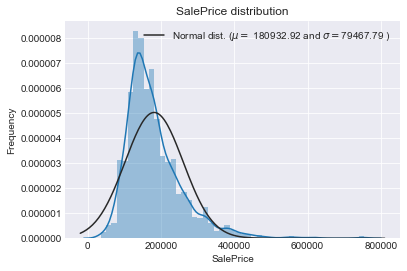

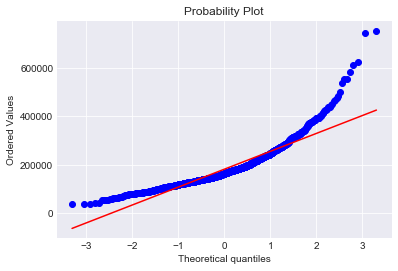

In [5]:
sns.distplot(train["SalePrice"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu,sigma))

# Now plot the distribution
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=${:.2f} )".format(mu,sigma)],
          loc = "best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot=plt)
plt.show()

The target variable is right skewed. As moels love normally distributed data, we need to transform this variable and make it more normally distributed.

### Log-transformation of the target variable


mu=12.02 and sigma = 0.40



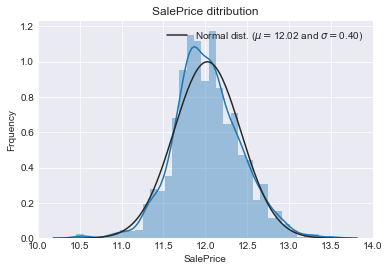

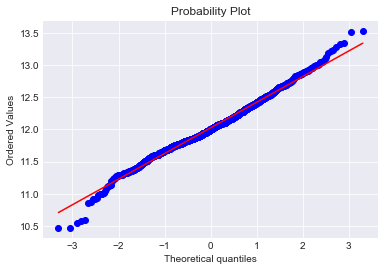

In [6]:
#We use the numpy function log1p which applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution
sns.distplot(train["SalePrice"] , fit=norm)

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print("\nmu={:.2f} and sigma = {:.2f}\n".format(mu,sigma))

#Now plot the ditribution
plt.legend(["Normal dist. ($\mu=${:.2f} and $\sigma=${:.2f})".format(mu,sigma)], loc="best")
plt.ylabel("Frquency")
plt.title("SalePrice ditribution")

#Get also QQ-plot
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot=plt)
plt.show()

The skew seems now corrected and the data appers more normally distributed.

### Features engineering
---
let's first concatenate the train and test data in the same datafrme

In [7]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
print("all_data'before : {}".format(all_data.shape))
all_data.drop(["SalePrice"], axis=1, inplace=True)
print("all_data'after : {}".format(all_data.shape))

all_data'before : (2917, 80)
all_data'after : (2917, 79)


### Missing Data

In [8]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Ratio":all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5,1,'Percent missing data by feature')

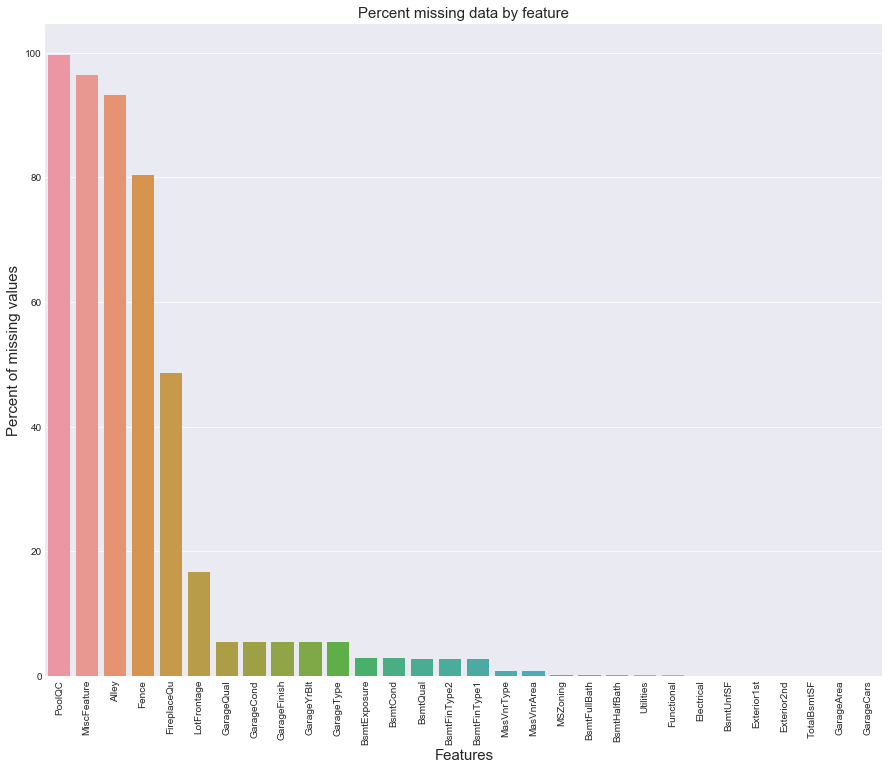

In [9]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percent of missing values", fontsize=15)
plt.title("Percent missing data by feature", fontsize=15)

### Data Correlation

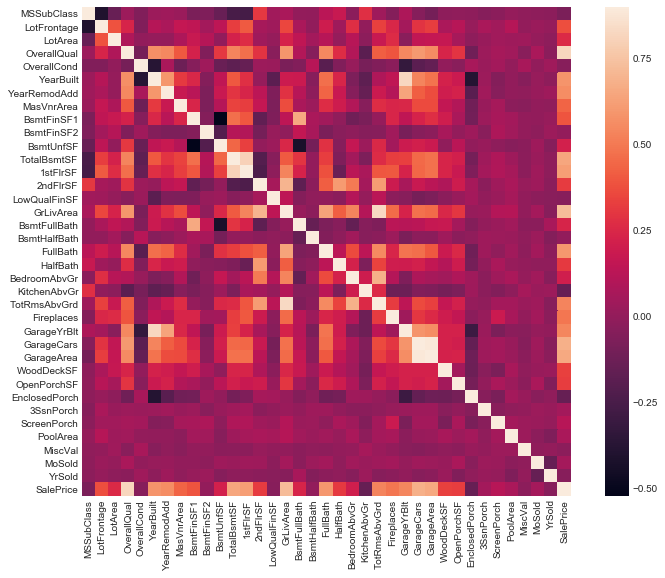

In [10]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Imputing missing values
---
We impute them by proceeding sequentially through features with missing values

- **PoolQC**: data description says NA means "No Pool". That make sense, given the huge ratio of missing value(+99%) and majority of houses have no Pool at all in general.

In [11]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["PoolQC"]

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
2887    None
2888    None
2889    None
2890    None
2891    None
2892    None
2893    None
2894    None
2895    None
2896    None
2897    None
2898    None
2899    None
2900    None
2901    None
2902    None
2903    None
2904    None
2905    None
2906    None
2907    None
2908    None
2909    None
2910    None
2911    None
2912    None
2913    None
2914    None
2915    None
2916    None
Name: PoolQC, Length: 2917, dtype: object

- **MiscFeature** : data description says NA means "no misc feature"

In [12]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [13]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [14]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [15]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood, we can fill in missing values by the median LotFrontage of the neighborhood.

In [16]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x:x.fillna(x.median()))

- **Garage Type, Garage Finish, GarageQual and GarageCond**: Replacing missing data with None

In [17]:
for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    all_data[col] = all_data[col].fillna("None")

- **GarageYrBlt, GarageArea and GarageCars** : 
  Replacing missing data with 0

In [18]:
for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [19]:
for col in ("BsmtFinSF1", 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure,BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is not a basement.

In [20]:
for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
    all_data[col] = all_data[col].fillna("None")

- **MasVnrArea and MasVnrType** :NA most likely means no masonry venner for these houses. We can fill 0 for the area and None for the type.

In [21]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZooning(The general zoning classification)** : "RL" is by far the most common value. So we can fill in missing values with "RL"

In [22]:
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA. Since the house with "NoSewa" is in the training set, **this feature will not help in predictive modelling**. We can then safely remove it.

In [23]:
all_data = all_data.drop(["Utilities"], axis=1)

- **Functional** : data description says NA means typical

In [24]:
all_data["Functional"] = all_data["Functional"].fillna("Type")

- **Electrical** : It has one NA values. Since this feature has mostly "SBrkr", we can set that for the missing value.

In [25]:
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"]).mode()[0]

- **KitchenQuel** : Only one NA value, and same as Electrical, we set "TA" for the missing value in KitchenQual 

In [26]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior 2nd** : Again Both Exteror 1&2 have only one missing value. We will just substitute in the most common string

In [27]:
for col in ("Exterior1st", "Exterior2nd"):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [28]:
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [29]:
all_data["MSSubClass"] = all_data["MSSubClass"].fillna("None")

Is there any remaining missing value?

### More features engeneering
- ------
Transforming some numerical variables that are really categorical

In [30]:
#MSSubClass = The building class
all_data["MSSubClass"] = all_data["MSSubClass"].apply(str)

#Changing OverallCond into a categorical variable
all_data["OverallCond"] = all_data["OverallCond"].astype(str)

#Year and month sold are transformed into categorical features.
all_data["YrSold"] = all_data["YrSold"].astype(str)
all_data["MoSold"] = all_data["MoSold"].astype(str)

#### Label Encoding some categorical variables that may contain information in their ordering set

In [31]:
from sklearn.preprocessing import LabelEncoder
cols = ("FireplaceQu","BsmtQual","BsmtCond","GarageQual","GarageCond","ExterQual","ExterCond","HeatingQC","PoolQC","KitchenQual","BsmtFinType1","BsmtFinType2","Functional","Fence","BsmtExposure","GarageFinish","LandSlope","LotShape","PavedDrive","Street","Alley","YrSold","MoSold")

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
print("Shape all_data: {}".format(all_data.shape))

Shape all_data: (2917, 78)


### Adding one more impotant feature
---
Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house.

In [32]:
# Adding total sqfootage feature
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]

### Skewed features

In [33]:

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({"Skew" :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372


### Box Cox Transformation of skewed features
---
We use the scipy function boxcox1p which computes the Box-Cox transformation of 1+x

Note that setting λ=0 is equivalent to log1p used above for the target variable.

- http://onlinestatbook.com/2/transformations/box-cox.html

In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewd numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 33 skewd numerical features to Box Cox transform


In [35]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 335)


In [36]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### Modelling
-----
Import libraries

In [37]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Define a cross validation strategy
------
We use the cross_val_score function of Sklearn. However this function has not a shuffle attribute, we add then one line of code to shuffle the dataset prior to cross-validation

In [38]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Base models
---
- **LASSO Regression**:
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline

In [39]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

- **Elastic et Regression**:
again made robust to outliers

In [40]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression**:

In [41]:
KRR = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)

- **Gradient Boosting Regression**:

With **huber** loss that makes it robust to outliers

In [42]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features="sqrt", min_samples_leaf=1.5, min_samples_split=10, loss="huber", random_state=5)

- **XGBoost**:

In [43]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)

AttributeError: module 'xgboost' has no attribute 'XGBRegressor'

###  Base models scores
---
Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [44]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1112 (+/-0.0065)



In [45]:
score = rmsle_cv(ENet)
print("\nElasticNet score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))


ElasticNet score: 0.1111 (+/-0.0066)



In [46]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1147 (+/-0.0056)



In [47]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

ValueError: min_samples_leaf must be at least 1 or in (0, 0.5], got 1.5

### Stacking models
---
#### Simplest stacking approach : Averaging base models


We begin with this simple approach of averaging base models. We use **object oriented programming** approach to extend scikit-learn with our model and also to laverage encapsulation and code reuse.

#### Averaged base models class

In [68]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

#### Averaged base models score
---
We just average four models here **ENet, GBoost, KRR and lasso.**
Of course we could easily add more models in the mix.

In [76]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

averaged_models

AveragingModels(models=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False...ve=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])))

#### Less simple Stacking : Adding a Meta-model
---
In this approach we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. We use again OOP approach for the same reasons as before.

#### Stacking averaged Models Class

In [67]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

#### Stacking Averaged models Score
---
To make the two approaches comparable, we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [77]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} (+/-{:.4f})".format(score.mean(), score.std()))

ValueError: min_samples_leaf must be at least 1 or in (0, 0.5], got 1.5

In [86]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

ValueError: min_samples_leaf must be at least 1 or in (0, 0.5], got 1.5

#### Submission

In [85]:
sub = pd.DataFrame()
sub["Id"] = test_ID
stacked_pred

NameError: name 'stacked_pred' is not defined

### Preprocessing

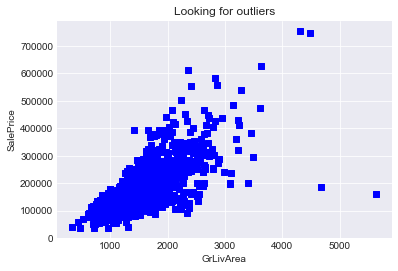

In [45]:
plt.scatter(train.GrLivArea, train.SalePrice, c= "blue", marker="s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing "any houses with more than 4000 square feet" from the dataset.

- https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

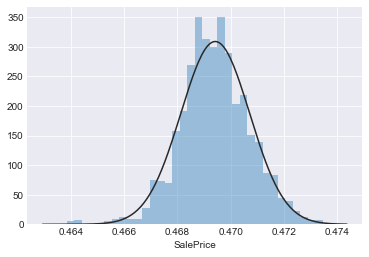

In [52]:
import scipy.stats as st
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice
sns.distplot(y, kde=False, fit=st.norm)

Taking logs means that errors in predicting expensive houses and cheap houses wil affect the result equally.

In [60]:
train.loc[:,"Alley"] = train.loc[:,"Alley"].fillna("None")
train.loc[:,"BedroomAbvGr"] = train.loc[:,"BedroomAbvGr"].fillna(0)
train.loc[:,"BsmtQual"] = train.loc[:,"BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [62]:
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [63]:
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Then we will create new features, in 3 ways:
- Simplifications of existing features

- Combinations of exsting features

- Polynomials on the top 10 existing features

In [80]:
# Create new features# Create new features
 # 1* Simplifications of existing features# 1* Simplifications of existing features

train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
    
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [84]:
#find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace=True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice              1.000
OverallQual            0.815
AllSF                  0.811
AllFlrsSF              0.724
GrLivArea              0.713
SimplOverallQual       0.705
GarageCars             0.679
ExterQual              0.674
TotalBath              0.672
GarageScore            0.654
GarageArea             0.653
TotalBsmtSF            0.637
SimplExterQual         0.630
SimplGarageScore       0.628
BsmtQual               0.613
1stFlrSF               0.608
OverallGrade           0.605
SimplBsmtQual          0.594
YearBuilt              0.590
FullBath               0.590
ExterGrade             0.583
YearRemodAdd           0.570
GarageYrBlt            0.546
FireplaceQu            0.544
TotRmsAbvGrd           0.530
SimplOverallGrade      0.528
FireplaceScore         0.515
SimplFireplaceQu       0.512
SimplFireplaceScore    0.490
Fireplaces             0.486
                       ...  
BedroomAbvGr           0.208
SimplBsmtCond          0

In [89]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [91]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude={"object"}).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 110
Categorical features : 31
